In [1]:
# %pip install --upgrade pip --user
# %pip install pandas==2.2.3
# %pip install SQLAlchemy==2.0.0

# #%pip install sqlalchemy --user
# %pip install numpy --user
%pip install mysql-connector-python --user
# %pip install matplotlib 
# %pip install subword-nmt


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
from sqlalchemy import create_engine

# Define database connection parameters
host="localhost"
port=3306
user="root"
password=""
database="thesisCurrent"
database2="thesisv6.9"

engine1 = create_engine(f'mysql+mysqlconnector://{user}:{password}@{host}/{database}')

engine2 = create_engine(f'mysql+mysqlconnector://{user}:{password}@{host}/{database2}')

query1 = """
SELECT uniprot, tdl FROM protein JOIN target ON protein.ID = target.ID;
"""
df1 = pd.read_sql(query1, engine1) #Current

query2 = """
SELECT uniprot, tdl FROM protein JOIN target ON protein.ID = target.ID;
"""
df2 = pd.read_sql(query2, engine2) #v6.9

def compare_versions(df1, df2):
    # Merge dataframes on 'uniprot'
    merged = df1.rename(columns={'tdl': 'TDL_current'}).merge(
        df2.rename(columns={'tdl': 'TDL_v6_9'}),
        on='uniprot',
        how='inner'
    )
    
    # Find proteins that were Tdark in v6.9 and reclassified in v6.11
    reclassified = merged[(merged['TDL_v6_9'] == 'Tdark') & (merged['TDL_current'] != 'Tdark')]
    
    return reclassified

reclassified_proteins = compare_versions(df1, df2)

print(f"Number of reclassified proteins: {len(reclassified_proteins)}")
uniprot_list = reclassified_proteins['uniprot'].tolist()

# Format the list for the SQL query
formatted_uniprot_list = "', '".join(uniprot_list)
print(len(uniprot_list))

# Query to get family information from idg_evol table
query_fam = f"""
SELECT DISTINCT uniprot, fam
FROM idg_evol
WHERE uniprot IN ('{formatted_uniprot_list}');
"""
fam_df = pd.read_sql(query_fam, engine1)

# Merge the family data with the reclassified proteins dataframe
reclassified_proteins_with_fam = reclassified_proteins.merge(fam_df, on='uniprot', how='left')

print(reclassified_proteins_with_fam)
print(f"Number of reclassified proteins: {len(reclassified_proteins_with_fam)}")


Number of reclassified proteins: 1742
1742
     uniprot TDL_current TDL_v6_9  fam
0     Q49A92        Tbio    Tdark  NaN
1     Q7L8W6        Tbio    Tdark  NaN
2     Q6UW02        Tbio    Tdark  NaN
3     Q5W186        Tbio    Tdark  NaN
4     Q9HC47        Tbio    Tdark  NaN
...      ...         ...      ...  ...
1737  Q5T1S8        Tbio    Tdark  NaN
1738  Q9BR09        Tbio    Tdark  NaN
1739  Q5VTT5        Tbio    Tdark  NaN
1740  P09131        Tbio    Tdark  NaN
1741  Q8IVL6        Tbio    Tdark  NaN

[1742 rows x 4 columns]
Number of reclassified proteins: 1742


In [3]:
if uniprot_list:
    formatted_uniprot_list = "', '".join(uniprot_list)
    
    query_data = f"""
    SELECT 
        p.uniprot AS uniprot,
        p.seq AS sequence,
        da.smiles AS smiles,
        da.act_value AS affinity,
        'drug_activity' AS source_table
    FROM 
        protein p
    JOIN 
        drug_activity da ON p.id = da.target_id
    WHERE 
        p.uniprot IN ('{formatted_uniprot_list}')
    UNION ALL

    SELECT 
        p.uniprot AS uniprot,
        p.seq AS sequence,
        ca.smiles AS smiles,
        ca.act_value AS affinity,
        'cmpd_activity' AS source_table
    FROM 
        protein p
    JOIN 
        target t ON p.id = t.id
    JOIN 
        cmpd_activity ca ON t.id = ca.target_id
    WHERE 
        p.uniprot IN ('{formatted_uniprot_list}')
    """
    
print(uniprot_list)
print(formatted_uniprot_list)

['Q49A92', 'Q7L8W6', 'Q6UW02', 'Q5W186', 'Q9HC47', 'Q96RT6', 'Q96A84', 'O14529', 'Q5SZL2', 'Q96LK0', 'Q9BU64', 'Q96MT7', 'Q8N1V2', 'Q8TBE1', 'Q8IV77', 'Q9H2P9', 'Q7Z7G2', 'P14406', 'Q6YFQ2', 'P57773', 'Q6PEY0', 'Q8IZJ3', 'Q8N4M1', 'Q05D32', 'Q9C0D2', 'Q9H4B8', 'Q96FN9', 'Q15006', 'Q9NWM3', 'A6NNW6', 'Q9P013', 'Q6UX04', 'Q86X02', 'Q9H6K1', 'Q96BP2', 'Q14184', 'Q4W4Y0', 'Q8N815', 'Q9BZ76', 'Q9Y2V0', 'Q8N0S6', 'Q96JM3', 'Q5JU00', 'Q8NEE6', 'O43731', 'Q4G0M1', 'O43414', 'Q8TE67', 'A0FGR9', 'P58658', 'Q17RW2', 'Q494V2', 'Q5T890', 'Q9UKR5', 'Q99680', 'Q96I76', 'Q9H501', 'Q5XG92', 'Q9NY74', 'P0C7U0', 'Q9UJA9', 'Q8IUS5', 'Q7Z2K6', 'Q9NS67', 'Q9BZJ7', 'Q9BZJ6', 'O95800', 'Q9Y2E6', 'Q14156', 'Q9H1K4', 'Q99944', 'Q6P9H5', 'Q9NXP7', 'Q8TF65', 'Q5NDL2', 'Q13868', 'Q8TC76', 'Q9H098', 'Q9UHW5', 'P33947', 'Q96CN9', 'O43812', 'Q9Y5R5', 'Q96G04', 'Q6P531', 'Q0PNE2', 'Q9NVF9', 'Q9BSJ2', 'Q96JB1', 'Q0VDD8', 'Q9NR20', 'Q96JC9', 'Q86Y13', 'Q6UWP2', 'Q9UKB3', 'Q9P109', 'Q9HCS5', 'Q7L9B9', 'Q3B7T1', 'Q14183',

In [4]:
import os
import pandas as pd
import numpy as np

data_df = pd.read_sql(query_data, engine1)
print("Num ", len(data_df))

data_df = data_df.rename(columns={'smiles': 'SMILES', 'sequence': 'Target Sequence'})

# Remove rows with NaN or non-string SMILES values
data_df = data_df[data_df['SMILES'].apply(lambda x: isinstance(x, str) and x.strip() != '')]
print("After removing bad: ",len(data_df))
# Get unique drugs and targets
all_drugs = data_df['SMILES'].unique()
all_targets = data_df['Target Sequence'].unique()



Num  498
After removing bad:  495


In [5]:
print(data_df['uniprot'])
uniprots_with_needed_data = data_df['uniprot']
query_family = f"""
SELECT DISTINCT uniprot, fam
FROM idg_evol
WHERE uniprot IN ('{uniprots_with_needed_data}');
"""

# Fetch the family data from the database
fam_df = pd.read_sql(query_family, engine1)

# Merge the family data with the reclassified proteins dataframe
uniprots_with_needed_data_with_fam = data_df.merge(fam_df, on='uniprot', how='left')

# Display results with the added family column
print(uniprots_with_needed_data_with_fam)

0      Q86TW2
1      P59539
2      P59542
3      Q7RTR8
4      Q9NYW1
        ...  
493    Q5U5Z8
494    Q5U5Z8
495    Q5U5Z8
496    Q5U5Z8
497    Q5U5Z8
Name: uniprot, Length: 495, dtype: object
    uniprot                                    Target Sequence  \
0    Q86TW2  MARKALKLASWTSMALAASGIYFYSNKYLDPNDFGAVRVGRAVATT...   
1    P59539  MITFLPIIFSILVVVTFVIGNFANGFIALVNSTEWVKRQKISFADQ...   
2    P59542  MMCFLLIISSILVVFAFVLGNVANGFIALVNVIDWVNTRKISSAEQ...   
3    Q7RTR8  MATELDKIFLILAIAEFIISMLGNVFIGLVNCSEGIKNQKVFSADF...   
4    Q9NYW1  MPSAIEAIYIILIAGELTIGIWGNGFIVLVNCIDWLKRRDISLIDI...   
..      ...                                                ...   
490  Q5U5Z8  MFPALETHLKQTIPDPYEDFMYRHLQYYGYFKAQRGSLPNSATHQH...   
491  Q5U5Z8  MFPALETHLKQTIPDPYEDFMYRHLQYYGYFKAQRGSLPNSATHQH...   
492  Q5U5Z8  MFPALETHLKQTIPDPYEDFMYRHLQYYGYFKAQRGSLPNSATHQH...   
493  Q5U5Z8  MFPALETHLKQTIPDPYEDFMYRHLQYYGYFKAQRGSLPNSATHQH...   
494  Q5U5Z8  MFPALETHLKQTIPDPYEDFMYRHLQYYGYFKAQRGSLPNSATHQH...   

           

In [6]:
merged_df = reclassified_proteins_with_fam.merge(
    uniprots_with_needed_data_with_fam,
    on='uniprot',
    how='inner'
)
print(merged_df.columns)

# Check for duplicate rows in the merged_df
duplicates = merged_df[merged_df.duplicated()]
print(f"Number of duplicate rows: {len(duplicates)}")

merged_df.drop_duplicates(subset=["SMILES", "uniprot", "affinity"], inplace=True)
print(len(merged_df))

# if not duplicates.empty:
#     print("Duplicate rows:")
#     print(duplicates)

Index(['uniprot', 'TDL_current', 'TDL_v6_9', 'fam_x', 'Target Sequence',
       'SMILES', 'affinity', 'source_table', 'fam_y'],
      dtype='object')
Number of duplicate rows: 185
310


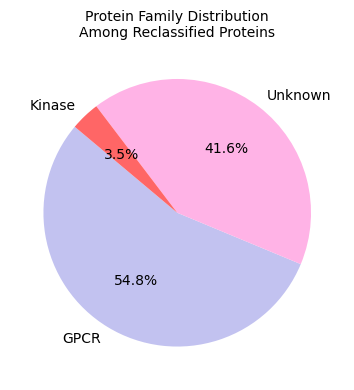

In [7]:
import matplotlib.pyplot as plt

# Count occurrences of each fam category, including NaN as 'Unknown'
fam_counts = merged_df['fam_x'].fillna('Unknown').value_counts()

fig, ax = plt.subplots(figsize=(4, 4))
ax.pie(fam_counts, labels=fam_counts.index, autopct='%1.1f%%', startangle=140, colors=['#c2c2f0','#ffb3e6','#ff6666','#66b3ff'])
ax.set_title("Protein Family Distribution\nAmong Reclassified Proteins", fontsize=10)
plt.tight_layout()
plt.show()


Data distribution by source table:
 source_table
cmpd_activity    295
drug_activity     15
Name: count, dtype: int64


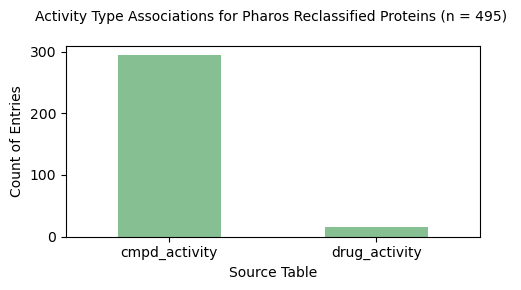

In [8]:
# Count of entries by source table
source_table_counts = merged_df['source_table'].value_counts()
print("Data distribution by source table:\n", source_table_counts)

plt.figure(figsize=(5, 3))
source_table_counts.plot(kind='bar', color='#86bf91')

plt.title("Activity Type Associations for Pharos Reclassified Proteins (n = 495) \n", fontsize=10)
plt.xlabel("Source Table", fontsize=10)
plt.ylabel("Count of Entries", fontsize=10)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



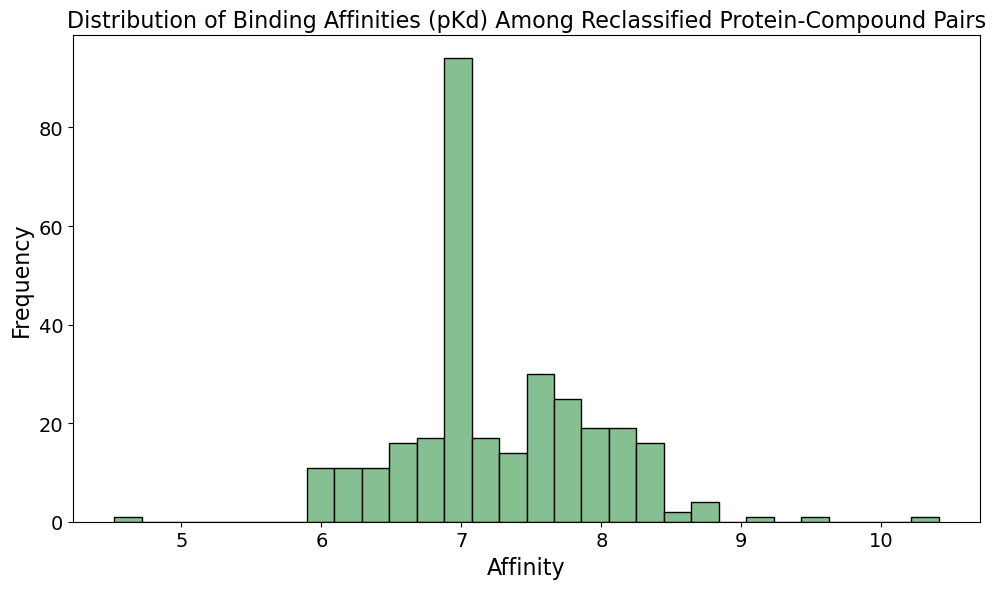

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(merged_df['affinity'], bins=30, color='#86bf91', edgecolor='black')

plt.title("Distribution of Binding Affinities (pKd) Among Reclassified Protein-Compound Pairs", fontsize=16)
plt.xlabel("Affinity", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()


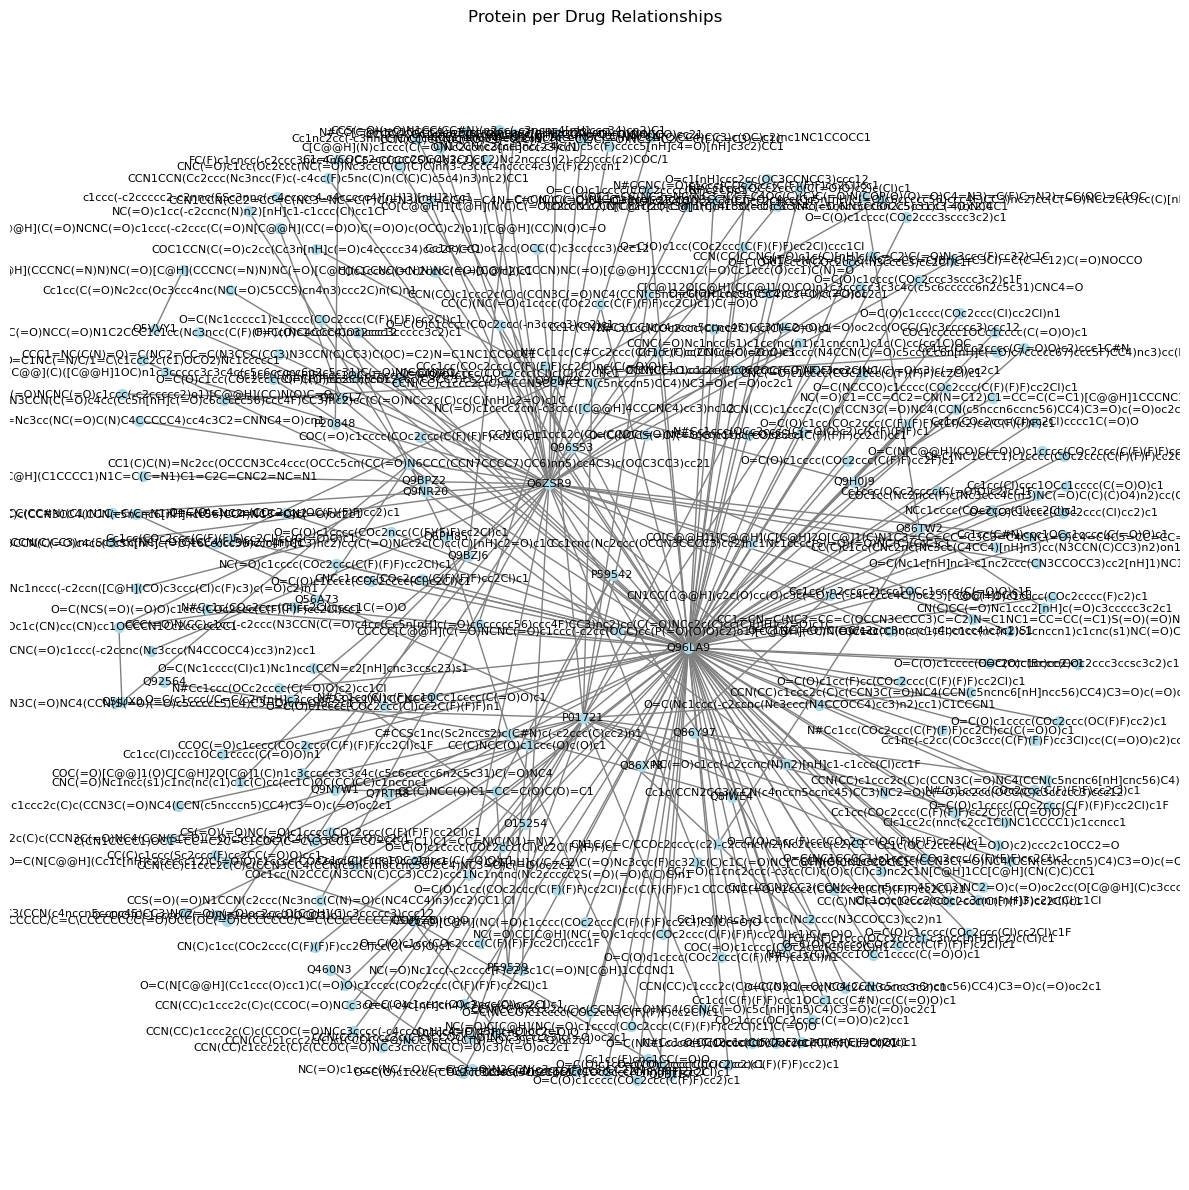

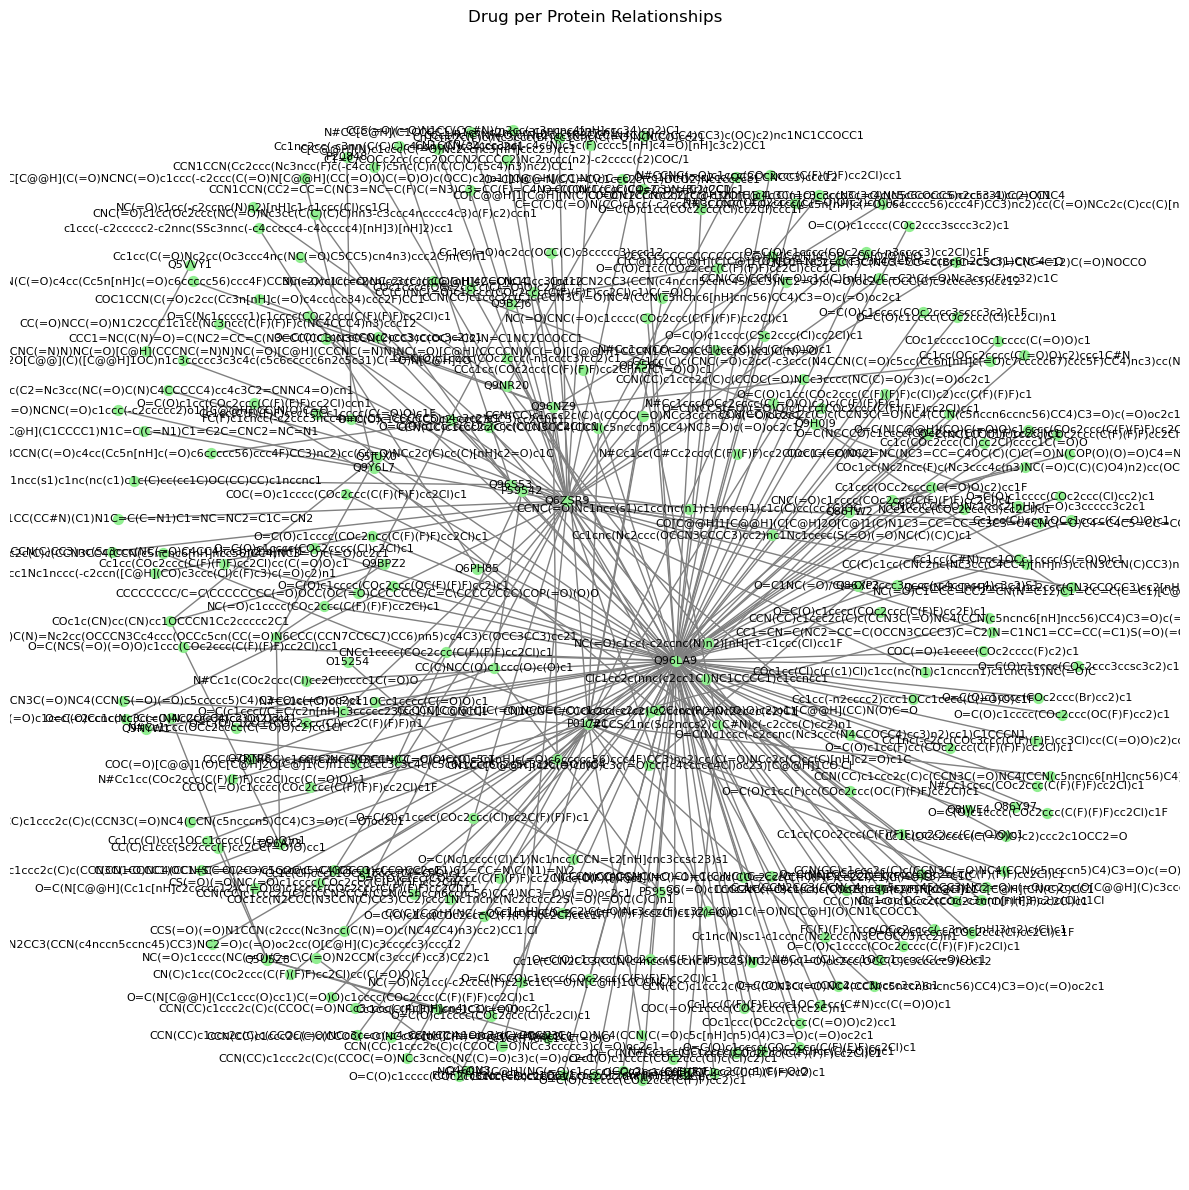

In [10]:
import networkx as nx
import matplotlib.pyplot as plt

G_protein_per_drug = nx.Graph()
G_drug_per_protein = nx.Graph()

# Create edges for Protein per Drug graph (Protein -> Drug)
for _, row in merged_df.iterrows():
    protein = row['uniprot']  # Protein identifiers
    drug = row['SMILES']      # SMILES as drug identifiers
    G_protein_per_drug.add_edge(drug, protein)

# Create edges for Drug per Protein graph (Drug -> Protein)
for _, row in merged_df.iterrows():
    protein = row['uniprot']  # Protein identifiers
    drug = row['SMILES']      # SMILES as drug identifiers
    G_drug_per_protein.add_edge(protein, drug)

# Plotting Protein per Drug
plt.figure(figsize=(12, 12))
plt.title("Protein per Drug Relationships")
pos = nx.spring_layout(G_protein_per_drug, k=0.5, seed=42) 
nx.draw(G_protein_per_drug, pos, with_labels=True, node_size=50, font_size=8, node_color='lightblue', edge_color='gray')
plt.tight_layout()
plt.show()

# Plotting Drug per Protein
plt.figure(figsize=(12, 12))
plt.title("Drug per Protein Relationships")
pos = nx.spring_layout(G_drug_per_protein, k=0.5, seed=42) 
nx.draw(G_drug_per_protein, pos, with_labels=True, node_size=50, font_size=8, node_color='lightgreen', edge_color='gray')
plt.tight_layout()
plt.show()


Number of proteins per drug (SMILES):
 count    209.000000
mean       1.062201
std        0.405440
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        4.000000
Name: uniprot, dtype: float64


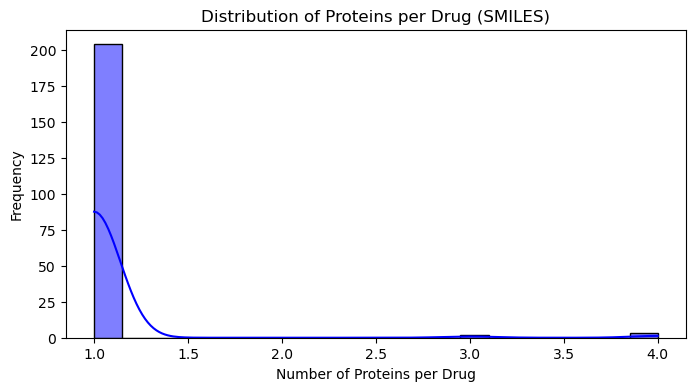

Number of drugs per protein:
 count     28.000000
mean       7.928571
std       20.173192
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max      101.000000
Name: SMILES, dtype: float64


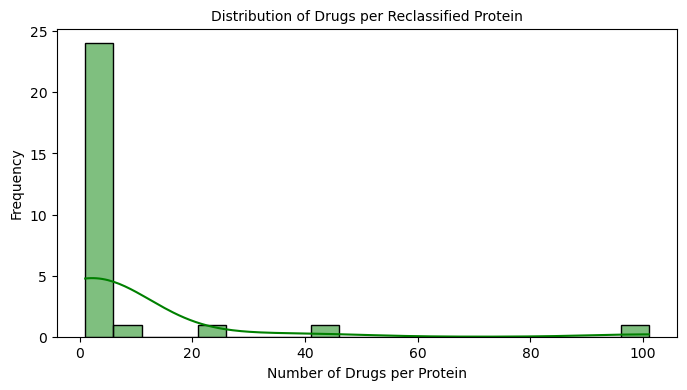

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Number of proteins per drug (SMILES)
protein_per_smiles = merged_df.groupby('SMILES')['uniprot'].nunique()
print("Number of proteins per drug (SMILES):\n", protein_per_smiles.describe())
plt.figure(figsize=(8, 4))
sns.histplot(protein_per_smiles, bins=20, kde=True, color='blue')
plt.title("Distribution of Proteins per Drug (SMILES)")
plt.xlabel("Number of Proteins per Drug")
plt.ylabel("Frequency")
plt.show()

# Number of drugs per protein
drug_per_protein = merged_df.groupby('uniprot')['SMILES'].nunique()
print("Number of drugs per protein:\n", drug_per_protein.describe())
plt.figure(figsize=(8, 4))
sns.histplot(drug_per_protein, bins=20, kde=True, color='green')
plt.title("Distribution of Drugs per Reclassified Protein", fontsize = 10)
plt.xlabel("Number of Drugs per Protein")
plt.ylabel("Frequency")
plt.show()


In [13]:

print(merged_df.columns)

# Check for duplicate rows based on Drug_ID, Protein_ID, and affinity
duplicates = merged_df[merged_df.duplicated(subset=["uniprot", "SMILES", "affinity"])]

# Print the number of duplicate rows
print(f"Number of duplicate rows (based on Drug_ID, Protein_ID, and affinity): {len(duplicates)}")

# Optionally, display the duplicate rows
if not duplicates.empty:
    print("Duplicate rows:")
    print(duplicates)

merged_df.drop_duplicates(subset=["SMILES", "uniprot", "affinity"], inplace=True)
print(len(merged_df))

Index(['uniprot', 'TDL_current', 'TDL_v6_9', 'fam_x', 'Target Sequence',
       'SMILES', 'affinity', 'source_table', 'fam_y'],
      dtype='object')
Number of duplicate rows (based on Drug_ID, Protein_ID, and affinity): 0
310


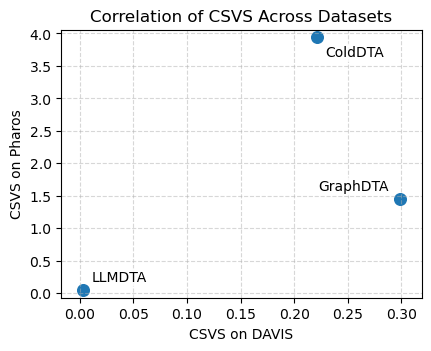

In [12]:
import matplotlib.pyplot as plt

models = ['GraphDTA', 'LLMDTA', 'ColdDTA']
x = [0.299, 0.0028, 0.221]   # DAVIS
y = [1.447, 0.049, 3.938]    # Pharos

fig, ax = plt.subplots(figsize=(4.2, 3.4), constrained_layout=True)
ax.scatter(x, y, s=70)

pad_x = 0.02
pad_y = 0.12
ax.set_xlim(min(x) - pad_x, max(x) + pad_x)
ax.set_ylim(min(y) - pad_y, max(y) + pad_y)

for xi, yi, m in zip(x, y, models):
    dx, dy = 6, 4 

    # nudge inward if near edges
    if xi > ax.get_xlim()[1] - 0.06:
        dx, ha = -8, 'right'
    else:
        ha = 'left'
    if yi > ax.get_ylim()[1] - 0.20:
        dy, va = -6, 'top'   # push label down
    else:
        va = 'bottom'

    ax.annotate(
        m, xy=(xi, yi), xytext=(dx, dy), textcoords='offset points',
        ha=ha, va=va,
        bbox=dict(boxstyle='round,pad=0.15', fc='white', ec='none', alpha=0.85),
        clip_on=False,            
        annotation_clip=False     
    )

ax.set_xlabel("CSVS on DAVIS")
ax.set_ylabel("CSVS on Pharos")
ax.set_title("Correlation of CSVS Across Datasets")
ax.grid(True, linestyle='--', alpha=0.5)

plt.show()
